In [ ]:
#| default_exp growthree

In [ ]:
#| export

import torch,numpy as np,math,matplotlib.pyplot as plt
import torchvision.transforms as tfms
from diffusers import StableDiffusionPipeline,AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler
from transformers import CLIPTokenizer,CLIPTextModel
from PIL import Image
import gc,os
from tqdm.auto import tqdm
from dataclasses import dataclass
from functools import partial

In [ ]:
#| hide
%matplotlib inline

In [ ]:
#| export
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

def release_cache():
    gc.collect()
    torch.cuda.empty_cache()

#把图片排成 rows,cols的网格中，先排cols,后排rows
#其中len(imgs)=cols x rows
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid
def isColab():
    try:
        import google.colab
        IN_COLAB = True
    except:
        IN_COLAB = False
    if IN_COLAB:
        print("当前环境是Colab")
    else:
        print("当前环境不是Colab")
    return IN_COLAB

## 超参设定

In [ ]:
#| export
@dataclass
class HiperParameter():
    prompts:tuple
    fps:int=1
    prompt_per_second:int=1
    
    seed=1000
    guide_factor:int=7.5
    num_inference:int=5
    start_step:int=0
    
    output_dir='grow_output'
tree_prompts =(
    "An oak tree with bare branches in the winter snowing blizzard bleak",
    "A barren oak tree with no leaves and grass on the ground",
    "An oak tree in the spring with bright green leaves",
    "An oak tree in the summer with dark green leaves with a squirrel on the trunk",
    "An oak tree in the fall with colorful leaves on the ground",
    "An barren oak tree with no leaves in the fall leaves on the ground long shadows",
    "An oak tree with bare branches in the winter snowing blizzard bleak"
)
hparam=HiperParameter(prompts=tree_prompts)


"An oak tree with bare branches in the winter snowing blizzard bleak"：一棵冬天光秃秃的橡树，在暴风雪中，景色凄凉。

"A barren oak tree with no leaves and grass on the ground"：一棵光秃秃的橡树，没有叶子，地上长满了草。

"An oak tree in the spring with bright green leaves"：一棵春天长满鲜绿叶子的橡树。

"An oak tree in the summer with dark green leaves with a squirrel on the trunk"：一棵夏天叶子深绿的橡树，树干上有一只松鼠。

"An oak tree in the fall with colorful leaves on the ground"：一棵秋天落叶满地的橡树，树叶色彩斑斓。

"An barren oak tree with no leaves in the fall leaves on the ground long shadows"：一棵秋天光秃秃的橡树，地上落满了树叶，形成了长长的阴影。

"An oak tree with bare branches in the winter snowing blizzard bleak"：一棵冬天光秃秃的橡树，在暴风雪中，景色凄凉。

## 模型定义

In [ ]:
modelName="CompVis/stable-diffusion-v1-4"
mirror='bfsu' if isColab() else None

if isColab():
    pipe = StableDiffusionPipeline.from_pretrained(modelName, 
                                                   revision="fp16", 
                                                   mirror=mirror,
                                                   torch_dtype=torch.float16)
    pipe.to(torch_device)

    vae=pipe.vae
    tokenizer=pipe.tokenizer
    text_encoder=pipe.text_encoder
    unet=pipe.unet
    schedular=pipe.scheduler
else:
    vae=AutoencoderKL.from_pretrained(modelName,subfolder='vae',mirror=mirror).to(torch_device)
    tokenizer=CLIPTokenizer.from_pretrained(modelName,subfolder="tokenizer",mirror=mirror)
    text_encoder=CLIPTextModel.from_pretrained(modelName,subfolder="text_encoder",mirror=mirror).to(torch_device)
    unet=UNet2DConditionModel.from_pretrained(modelName,subfolder='unet',mirror=mirror).to(torch_device)
    schedular=LMSDiscreteScheduler(beta_schedule='scaled_linear',beta_start=0.00085, beta_end=0.012 )

当前环境不是Colab


In [ ]:
#| export
@torch.no_grad()
def pil2Latents(input_image:Image)-> torch.FloatTensor:
    '''
    把图片转换成vae的输入，生成的tensor已经移torch_device上了
    返回：size=[1,4,64,64]
    '''
    def tfms2Latent(r):
        return 2*r-1
    ts=tfms.ToTensor()(input_image).unsqueeze(0)
    ts=tfms2Latent(ts).to(vae.device)
    return 0.18215*vae.encode(ts).latent_dist.sample()
@torch.no_grad()
def latents2Pil(latents:torch.FloatTensor) ->Image:
    '''
    把隐变量还原成PIL.Image
    latents: FloatTensor,size=[1,4,64,64]
    '''
    def tfms2Img(r):
        r=(0.5*r+0.5)
        return r.float().clamp(0,1)
    decode_img=vae.decode(latents/0.18215).sample.detach().cpu()
    decode_img=decode_img.permute(0,2,3,1).squeeze()
    decode_img=tfms2Img(decode_img)

    arr_img=decode_img.numpy()*255
    arr_img=arr_img.astype('uint8')
    return Image.fromarray(arr_img)

## 准备嵌入层

In [ ]:
!wget -O oak_tree.jpg "https://github.com/johnrobinsn/diffusion_experiments/blob/scenario1/images/oak_tree.jpg?raw=true"

--2023-05-19 12:45:15--  https://github.com/johnrobinsn/diffusion_experiments/blob/scenario1/images/oak_tree.jpg?raw=true
正在连接 127.0.0.1:7890... 已连接。
已发出 Proxy 请求，正在等待回应... 302 Found
位置：https://github.com/johnrobinsn/diffusion_experiments/raw/scenario1/images/oak_tree.jpg [跟随至新的 URL]
--2023-05-19 12:45:16--  https://github.com/johnrobinsn/diffusion_experiments/raw/scenario1/images/oak_tree.jpg
再次使用存在的到 github.com:443 的连接。
已发出 Proxy 请求，正在等待回应... 302 Found
位置：https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/scenario1/images/oak_tree.jpg [跟随至新的 URL]
--2023-05-19 12:45:16--  https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/scenario1/images/oak_tree.jpg
正在连接 127.0.0.1:7890... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度：129112 (126K) [image/jpeg]
正在保存至: “oak_tree.jpg”

oak_tree.jpg        100%[===================>] 126.09K   483KB/s  用时 0.3s      

2023-05-19 12:45:16 (483 KB/s) - 已保存 “oak_tree.jpg” [129112/129112])



In [ ]:
tree_path='oak_tree.jpg'

img=Image.open(tree_path)
img_latent=pil2Latents(img)

no_guide_ids=tokenizer("",padding='max_length',max_length=tokenizer.model_max_length,return_tensors='pt').input_ids
guide_ids=tokenizer(hparam.prompts,padding='max_length',max_length=tokenizer.model_max_length,return_tensors='pt').input_ids


with torch.no_grad():
    ids=torch.cat([no_guide_ids,guide_ids]).to(torch_device)
    token_emb=text_encoder(ids).last_hidden_state
uncondition_token_emb=token_emb[0]
prompts_token_emb=token_emb[1:]


def mix_embbed_and_uncond(i,j,wi,wj,V,u):
    v=V[i]*wi+V[j]*wj
    return torch.stack([u,v])
mix_frame_emb=partial(mix_embbed_and_uncond,V=prompts_token_emb,u=uncondition_token_emb)


**注意** 使用partial的函数，需要赋值的参数要在参数列表的最后面

## 生成每一帧图像

In [ ]:
#| export

def generate_baseon_prompt_emb(img_latent:torch.FloatTensor,token_emb:torch.FloatTensor,pbar=None)->(Image,torch.FloatTensor):
    '''
        :param token_emb: img_latent 图像的隐变量,(2,4,64,64)的tensor
        :param token_emb: 句子经过clip_encoder后的向量表示,(2,T,D) 
        :return:  denoise 后的图片
    '''
    if hparam.seed>=0:
        torch.manual_seed(hparam.seed)
    start_step=hparam.start_step
    schedular.set_timesteps(hparam.num_inference)
    
    init_noise=torch.randn_like(img_latent)
    img_latent=schedular.add_noise(img_latent,init_noise,schedular.timesteps[start_step:start_step+1])

    if pbar is None:
        pbar=tqdm(range(len(schedular.timesteps)))
    with torch.no_grad():
        for s in range(len(schedular.timesteps)):
            if s>=start_step:
                t=schedular.timesteps[s]
                inp=torch.concat([img_latent,img_latent])
                inp=schedular.scale_model_input(inp,t)

                noise=unet(inp,t,encoder_hidden_states=token_emb).sample

                pred_noise=noise[0]+hparam.guide_factor*(noise[1]-noise[0])
                # pred_noise=pred_noise/pred_noise.norm()*noise[0].norm()
                img_latent=schedular.step(pred_noise,t,img_latent).prev_sample
            pbar.update(1)
    return latents2Pil(img_latent),img_latent


重点先测试这2个函数是否好用

  0%|          | 0/5 [00:00<?, ?it/s]

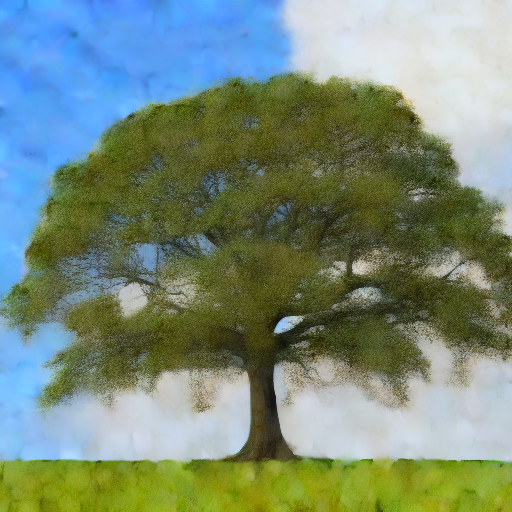

In [ ]:
#| hide
hparam.num_inference=5
hparam.start_step=3
hparam.seed=17390125398225616219
tx=mix_frame_emb(0,1,0,1)
frame,frame_latent=generate_baseon_prompt_emb(img_latent,tx)
frame

In [ ]:
! rm -rf {hparam.output_dir}

生成每一帧的代码

In [ ]:
os.makedirs(hparam.output_dir,exist_ok=True)

num_of_prompt=len(hparam.prompts)
num_of_generate_frame=(num_of_prompt-1)*hparam.prompt_per_second*hparam.fps
pbar=tqdm(range(num_of_generate_frame*hparam.num_inference))



def mapfunc(t):
    '''
        把每一帧映射到对应的prompt索引
    '''
    frac_index=t*(num_of_prompt-1)/(num_of_generate_frame-1)
    index1,index2=math.floor(frac_index),math.floor(frac_index)+1
    weight1,weight2=index2-frac_index,frac_index-index1
    
    if index2>num_of_prompt-1:
        index2=0
    return index1,index2,weight1,weight2    

#  (0, 1, 0.2941176470588235, 0.7058823529411765)
for k,e in enumerate(map(mapfunc,range(num_of_generate_frame))):
    pbar.set_description(f'Frame {k:05d}')
    mix_frame_emb(*e)
    frame,frame_latent=generate_baseon_prompt_emb(img_latent,text_emb,pbar)
    frame.save(f"{hparam.output_dir}/{k:05d}.jpg")